<a href="https://colab.research.google.com/github/Anushadhirde/Semantic_Segmentation_for_Road_Scene_Understanding/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade


In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sovitrath/indian-driving-dataset-segmentation-part-2")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anushadhirde
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sovitrath/indian-driving-dataset-segmentation-part-2


100%|██████████| 5.26G/5.26G [01:16<00:00, 74.0MB/s]


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# Install necessary packages
!pip install albumentations==1.3.0
!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.6
    Uninstalling albumentations-2.0.6:
      Successfully uninstalled albumentations-2.0.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T


In [ ]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class IDDSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_mask_pairs = self.match_images_and_masks()

    def match_images_and_masks(self):
        images = sorted(os.listdir(self.image_dir))
        masks = sorted(os.listdir(self.mask_dir))
        pairs = []

        for img in images:
            base = img.replace("_leftImg8bit.jpg", "")
            mask_name = base + "_gtFine_polygons.png"
            if mask_name in masks:
                pairs.append((img, mask_name))
        return pairs

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.image_mask_pairs[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))  # already grayscale with labels

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask.long()


In [ ]:
from torch.utils.data import DataLoader

transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
import os

train_images = "/content/IDD_Segmentation/idd_part_2/train/images"
train_masks = "/content/IDD_Segmentation/idd_part_2/train/gray_labels"

print("Images:")
print(os.listdir(train_images)[:5])  # print first 5 image files

print("\nMasks:")
print(os.listdir(train_masks)[:5])  # print first 5 mask files


Images:
['0002821_leftImg8bit.jpg', 'frame5139_leftImg8bit.jpg', 'frame11735_leftImg8bit.jpg', 'frame21785_leftImg8bit.jpg', 'frame15921_leftImg8bit.jpg']

Masks:
['frame7284_gtFine_polygons.png', 'frame20953_gtFine_polygons.png', '0016795_gtFine_polygons.png', 'frame22851_gtFine_polygons.png', 'frame14730_gtFine_polygons.png']


In [ ]:
train_dataset = IDDSegmentationDataset(train_images, train_masks, transform=transform)
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

5966


In [ ]:
images, masks = next(iter(train_loader))
print(images.shape)  # Should be [4, 3, 256, 256] (if resized to 256x256)
print(masks.shape)   # Should be [4, 256, 256]


torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [ ]:
import torchvision.models.segmentation as models
import torch.nn as nn

model = models.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 26, kernel_size=1)  # 26 classes
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 173MB/s]


In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(2):  # small number for test
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")


100%|██████████| 1492/1492 [11:10<00:00,  2.22it/s]


Epoch 1 - Loss: 0.8106


100%|██████████| 1492/1492 [10:49<00:00,  2.30it/s]

Epoch 2 - Loss: 0.4995


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/idd_deeplabv3_model.pth")


In [ ]:

model.load_state_dict(torch.load('/content/drive/MyDrive/idd_deeplabv3_model.pth', map_location='cpu'))  # use 'cuda' if on GPU
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

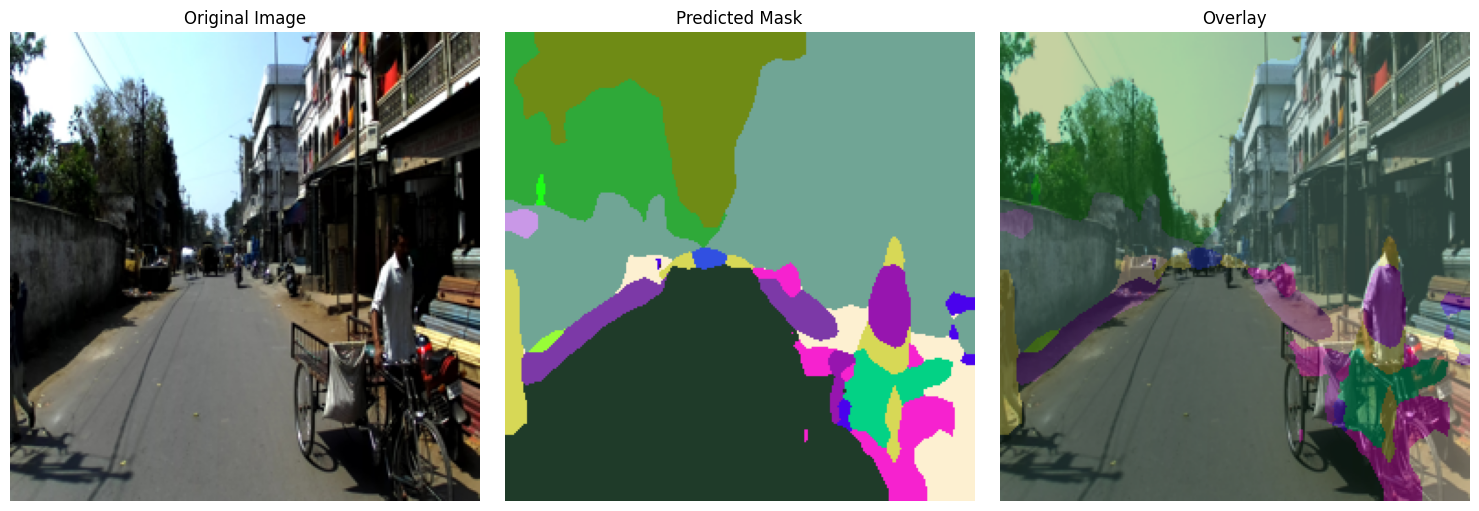

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as T

# Load a test image
img_path = "/content/IDD_Segmentation/idd_part_2/train/images/frame44817_leftImg8bit.jpg"
input_image = Image.open(img_path).convert("RGB")

# Preprocess image
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])
input_tensor = transform(input_image).unsqueeze(0).to(device)  # shape: [1, 3, 256, 256]

# Put model in eval mode and predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)['out']
    predicted_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # shape: [256, 256]

# Generate color map for 27 classes
colors = np.random.randint(0, 255, size=(27, 3), dtype=np.uint8)

# Convert predicted mask to color
colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
for class_id in range(27):
    colored_mask[predicted_mask == class_id] = colors[class_id]

# Resize original image for overlay
resized_input = np.array(input_image.resize((256, 256)))

# Overlay mask
overlay = cv2.addWeighted(resized_input, 0.6, colored_mask, 0.4, 0)

# Show all
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(resized_input)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(colored_mask)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()


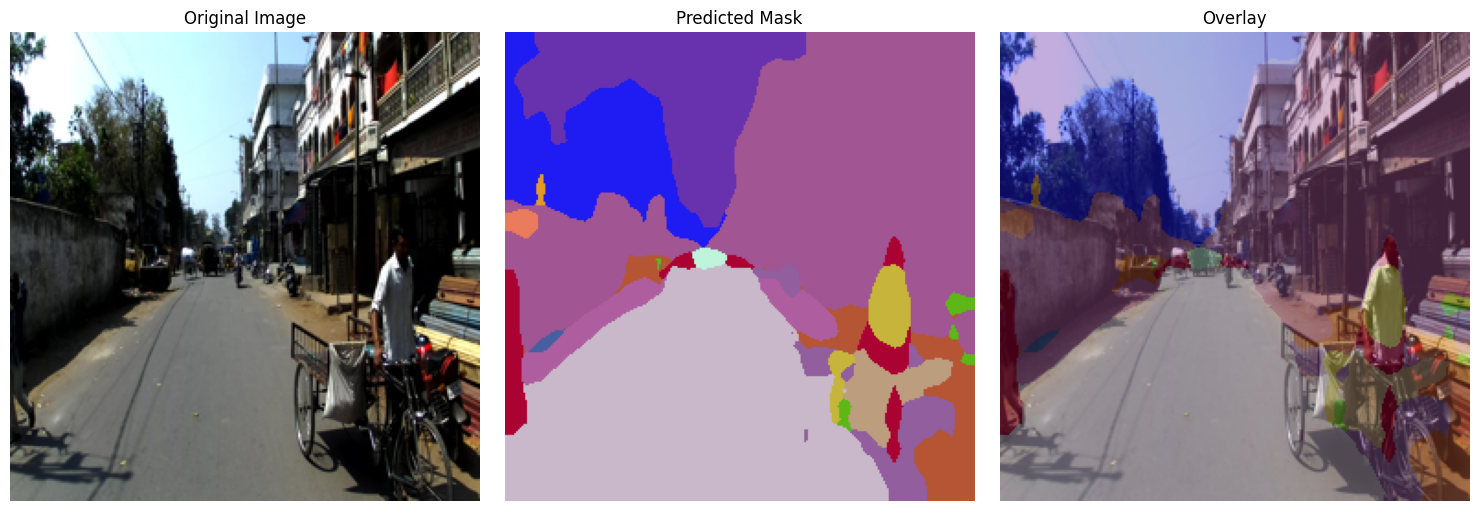

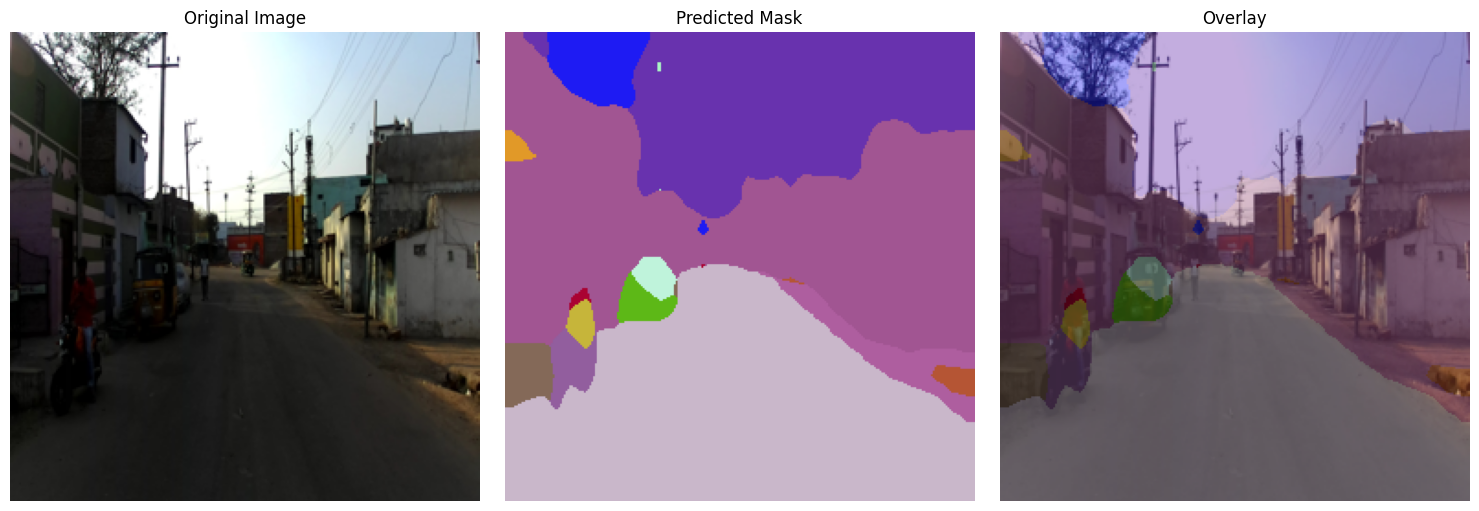

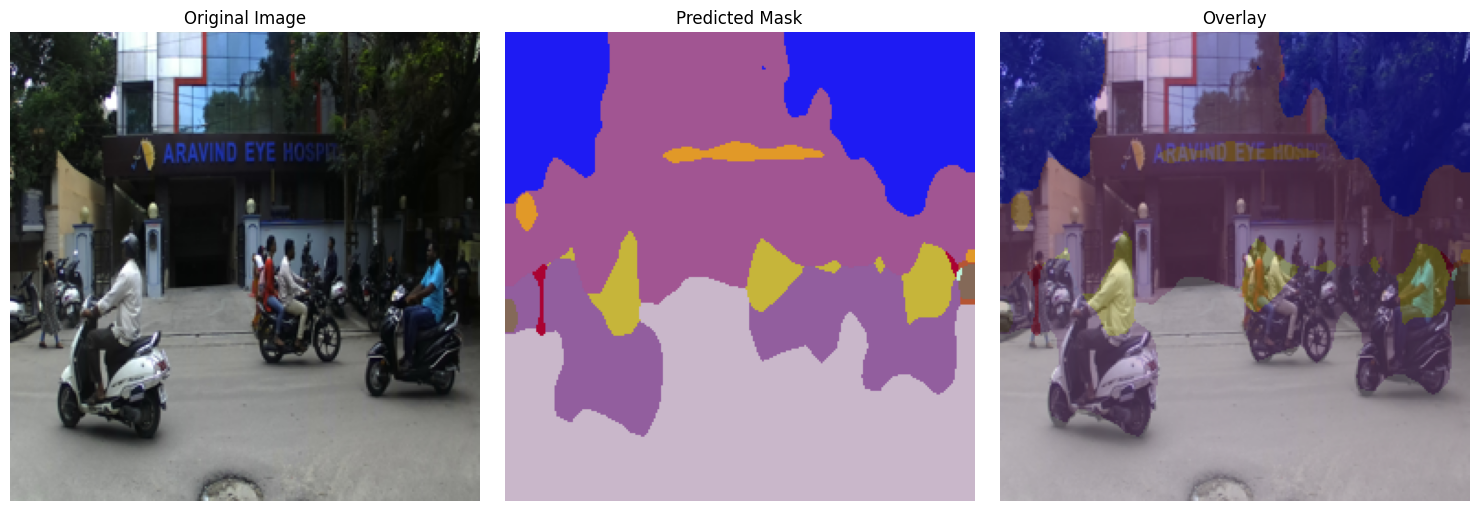

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as T

# List of image paths you want to visualize
image_paths = [
    "/content/IDD_Segmentation/idd_part_2/train/images/frame44817_leftImg8bit.jpg",
    "/content/IDD_Segmentation/idd_part_2/train/images/frame1449_leftImg8bit.jpg",
    "/content/IDD_Segmentation/idd_part_2/train/images/0003323_leftImg8bit.jpg",
    # add more images here...
]

# Preprocessing transform
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225))
])

# Generate fixed color map once for all images
colors = np.random.randint(0, 255, size=(27, 3), dtype=np.uint8)

model.eval()  # set model to eval mode

for img_path in image_paths:
    input_image = Image.open(img_path).convert("RGB")
    input_tensor = transform(input_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        predicted_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_id in range(27):
        colored_mask[predicted_mask == class_id] = colors[class_id]

    resized_input = np.array(input_image.resize((256, 256)))
    overlay = cv2.addWeighted(resized_input, 0.6, colored_mask, 0.4, 0)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(resized_input)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(colored_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
class_names = [
    "Road", "Sidewalk", "Building", "Wall", "Fence", "Pole", "Traffic Light",
    "Traffic Sign", "Vegetation", "Terrain", "Sky", "Person", "Rider", "Car",
    "Truck", "Bus", "Train", "Motorcycle", "Bicycle", "Unlabeled", "Class20",
    "Class21", "Class22", "Class23", "Class24", "Class25", "Ignore"
]


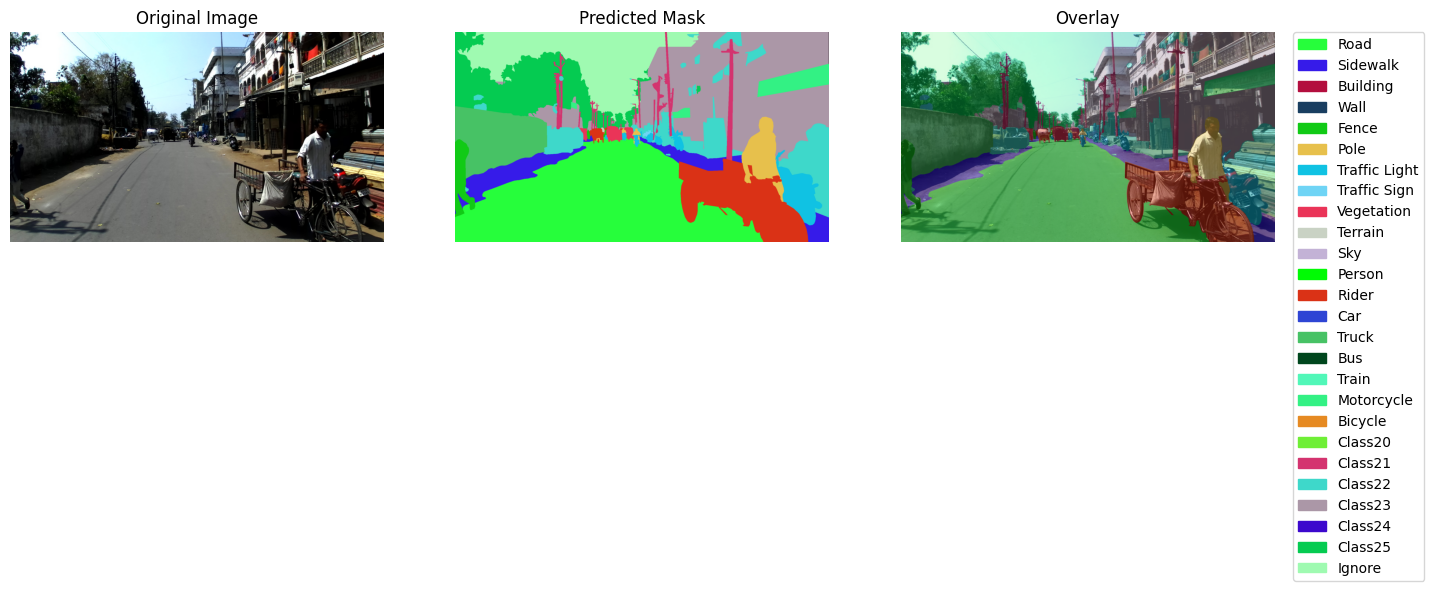

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2

# Replace with your actual class names
class_names = [
    "Road", "Sidewalk", "Building", "Wall", "Fence", "Pole", "Traffic Light",
    "Traffic Sign", "Vegetation", "Terrain", "Sky", "Person", "Rider", "Car",
    "Truck", "Bus", "Train", "Motorcycle", "Bicycle", "Class20", "Class21",
    "Class22", "Class23", "Class24", "Class25", "Ignore"
]

# Fixed color map for classes (same as before)
colors = np.random.randint(0, 255, size=(len(class_names), 3), dtype=np.uint8)

def load_image(path):
    # Load image from path in RGB format
    img = cv2.imread(path)  # BGR format by default
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_mask(path):
    # Load grayscale mask image (each pixel is class id)
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return mask

def visualize_segmentation(image, predicted_mask):
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for class_id in range(len(class_names)):
        colored_mask[predicted_mask == class_id] = colors[class_id]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(colored_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    overlay = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    plt.imshow(overlay)
    plt.axis('off')

    patches = [mpatches.Patch(color=colors[i]/255, label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Usage example with your image and mask paths
image_path = "/content/IDD_Segmentation/idd_part_2/train/images/frame44817_leftImg8bit.jpg"
mask_path = "/content/IDD_Segmentation/idd_part_2/train/gray_labels/frame44817_gtFine_polygons.png"

image = load_image(image_path)
mask = load_mask(mask_path)

visualize_segmentation(image, mask)


In [ ]:
from glob import glob
import os

def get_image_mask_pairs(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

    # Extract common keys by trimming the unique parts
    image_dict = {os.path.basename(p).replace('_leftImg8bit.jpg', ''): p for p in image_paths}
    mask_dict = {os.path.basename(p).replace('_gtFine_polygons.png', ''): p for p in mask_paths}

    images = []
    masks = []

    for key in image_dict:
        if key in mask_dict:
            images.append(image_dict[key])
            masks.append(mask_dict[key])

    print(f"✅ Found {len(images)} image-mask pairs in validation set.")
    return images, masks


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class IDDSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask


In [ ]:
import os

print("Image dir contents:", os.listdir("/content/IDD_Segmentation/idd_part_2/val/images")[:5])
print("Mask dir contents:", os.listdir("/content/IDD_Segmentation/idd_part_2/val/gray_labels")[:5])


Image dir contents: ['frame11556_leftImg8bit.jpg', 'frame6455_leftImg8bit.jpg', 'frame1793_leftImg8bit.jpg', 'frame27088_leftImg8bit.jpg', '0025963_leftImg8bit.jpg']
Mask dir contents: ['frame6455_gtFine_polygons.png', 'frame16686_gtFine_polygons.png', '0000736_gtFine_polygons.png', 'frame0144_gtFine_polygons.png', '0013764_gtFine_polygons.png']


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
import glob

val_img_dir = '/content/IDD_Segmentation/idd_part_2/val/images'
val_mask_dir = '/content/IDD_Segmentation/idd_part_2/val/gray_labels'

val_images = sorted(glob.glob(os.path.join(val_img_dir, '*.jpg')))
val_masks = sorted(glob.glob(os.path.join(val_mask_dir, '*.png')))

print(f"✅ Found {len(val_images)} image-mask pairs in validation set.")


✅ Found 1016 image-mask pairs in validation set.


In [ ]:
from torch.utils.data import DataLoader

val_dataset = IDDSegmentationDataset(val_images, val_masks, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
import numpy as np

def pixel_accuracy(pred_mask, true_mask):
    valid = true_mask >= 0
    correct = (pred_mask == true_mask) & valid
    return np.sum(correct) / np.sum(valid)

def mean_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        target_inds = (true_mask == cls)
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    miou = np.nanmean(ious)
    return miou, ious


In [ ]:
model.eval()
total_pixel_acc = 0
total_miou = 0
num_batches = 0

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        targets = masks.cpu().numpy()

        for pred_mask, true_mask in zip(preds, targets):
            pa = pixel_accuracy(pred_mask, true_mask)
            miou, _ = mean_iou(pred_mask, true_mask, num_classes=27)
            total_pixel_acc += pa
            total_miou += miou
            num_batches += 1

avg_pixel_acc = total_pixel_acc / num_batches
avg_miou = total_miou / num_batches

print(f"✅ Pixel Accuracy: {avg_pixel_acc:.4f}")
print(f"✅ Mean IoU: {avg_miou:.4f}")


✅ Pixel Accuracy: 0.8291
✅ Mean IoU: 0.3529
